In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import time

import gensim

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import re

import os
 

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB


nltk.download('stopwords')

np.set_printoptions(suppress=True)  # no usar notacion "e"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablonicolasr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read Dataset

# Dataset Details
# messages : the text of news
# labels   : type of news(neutral,positive,negative)
# target   : the polarity of the news (0 = negative, 2 = neutral, 4 = positive)

In [3]:
os.getcwd()

'C:\\Users\\pablonicolasr\\Desktop\\pablonicolas\\mentodatos\\mentodatos\\tercerentrega'

# Declaramos la ruta principal
google_drive = "/content/gdrive"
root_path = os.path.join(google_drive, "My Drive", "Colab Notebooks", "Mentoria_Datasets")

drive.mount(google_drive, force_remount = True)

In [4]:
# load dataset
news_df = pd.read_csv(os.path.join(os.getcwd(), "data", "sentPositiveall-data.csv"), names=["label", "text"], encoding = "ISO-8859-1")

news_df = news_df[["text", "label"]]

news_df.head()

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [5]:
# Check for nulll values
news_df.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
# Shape of our dataset
news_df.shape

(4846, 2)

# Se declara funcion para limpiar pantalla

In [7]:
def limpiar_pantalla():
    
    return os.system("cls" if os.name=="nt" else "clear")

### La celda que sigue es para trabajar con o sin la clase 'neutral'

In [8]:
band = False

while not band:
    
    a = input("Se considera la clase neutra? (S/N)").upper()

    if "S" in a:    
        # Se considera la clase neutra
        df_copy = news_df.copy()
        band = True
    
    elif "N" in a:
    
        df_copy = news_df[news_df["label"] != "neutral"]              # No se considera la clase neutra
        df_copy.reset_index(level=None, drop=True, inplace=True)    
        band = True
    else:
        
        input("SELECCIONE UNA OPCION VALIDA PARA CONTINUAR")
        limpiar_pantalla()
    
df_copy.head()

Se considera la clase neutra? (S/N)s


,text,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [9]:
df_copy.shape

(4846, 2)

# Map target label to String
 0 -> NEGATIVE
 2 -> NEUTRAL
 4 -> POSITIVE

In [10]:
# Map target label to String
# 0 -> NEGATIVE
# 2 -> NEUTRAL
# 4 -> POSITIVE

def func(df):
    if df == 'neutral':
        return 0
    elif df == 'negative':
        return -1
    else:
        return 1
    
df_copy['target'] = df_copy.label.apply(func)
df_copy.head()

,text,label,target
0,"According to Gran , the company has no plans t...",neutral,0
1,Technopolis plans to develop in stages an area...,neutral,0
2,The international electronic industry company ...,negative,-1
3,With the new production plant the company woul...,positive,1
4,According to the company 's updated strategy f...,positive,1


# Count plot for labels feature

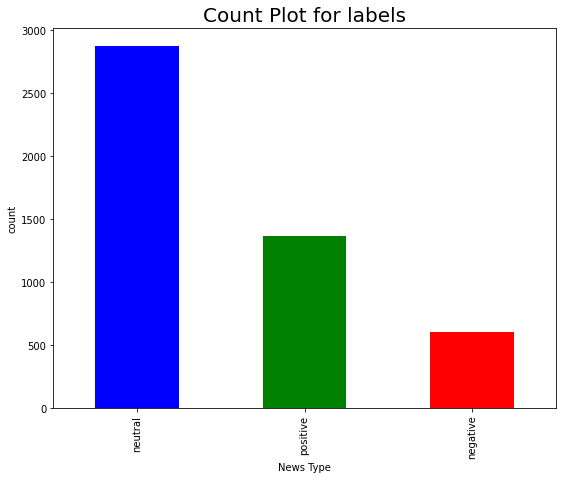

In [11]:
plt.figure(figsize=(9,7))

df_copy.label.value_counts().plot(kind='bar',color=['blue','green','red'])

plt.xlabel("News Type")
plt.ylabel("count")

plt.title("Count Plot for labels",{'fontsize':20});

# Text preprocessing

In [12]:
df_copy.head()

,text,label,target
0,"According to Gran , the company has no plans t...",neutral,0
1,Technopolis plans to develop in stages an area...,neutral,0
2,The international electronic industry company ...,negative,-1
3,With the new production plant the company woul...,positive,1
4,According to the company 's updated strategy f...,positive,1


In [13]:
corpus = []

#Object for porterstem
ps = PorterStemmer()

for i in range(len(df_copy)):
    text = re.sub(r'[^a-zA-Z]',' ',df_copy.text[i])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    corpus.append(text)

In [14]:
corpus

['accord gran compani plan move product russia although compani grow',
 'technopoli plan develop stage area less squar meter order host compani work comput technolog telecommun statement said',
 'intern electron industri compani elcoteq laid ten employe tallinn facil contrari earlier layoff compani contract rank offic worker daili postime report',
 'new product plant compani would increas capac meet expect increas demand would improv use raw materi therefor increas product profit',
 'accord compani updat strategi year baswar target long term net sale growth rang oper profit margin net sale',
 'financ aspocomp growth aspocomp aggress pursu growth strategi increasingli focus technolog demand hdi print circuit board pcb',
 'last quarter componenta net sale doubl eur eur period year earlier move zero pre tax profit pre tax loss eur',
 'third quarter net sale increas eur mn oper profit eur mn',
 'oper profit rose eur mn eur mn correspond period repres net sale',
 'oper profit total eur mn e

## Se aplica word2vec desde aquí

Training Word Embeddings
Until here I did not explain code so much with markdowns but the thing starts here so let's explain what will we do in this section.

In this section we're going to train word embeddings using our data and in order to train those word vectors we'll tokenize our data.

Tokenizing basically means splitting sentences into words (e.g. You are nice => ["You","are","nice"]) Then we'll train our model using gensim. I won't get into details of word2vec but you should learn them because if you don't know how they work it's meaningless to use it

In [15]:
x_tokenized = [[w for w in sentence.split(" ") if w != ""] for sentence in corpus]

x_tokenized[0]

['accord',
 'gran',
 'compani',
 'plan',
 'move',
 'product',
 'russia',
 'although',
 'compani',
 'grow']

In [16]:
start = time.time()

model = gensim.models.Word2Vec(
    x_tokenized,
    vector_size=100
     # Size is the length of our vector.
)

end = round(time.time() - start, 2)

print(f"This process took {end} seconds.")

This process took 0.13 seconds.


In [17]:
model.wv.most_similar("total")

[('decreas', 0.9991085529327393),
 ('tax', 0.9985752701759338),
 ('sale', 0.99793940782547),
 ('usd', 0.9974462389945984),
 ('year', 0.9972335696220398),
 ('versu', 0.9972292184829712),
 ('month', 0.9971950650215149),
 ('first', 0.9969046711921692),
 ('oper', 0.9966498017311096),
 ('million', 0.9955092668533325)]

Writing A Class To Create Sequences
Our model is ready, but we need a class to convert texts to create word embedding sequences

In [18]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = Vocab which has all the unique words
        self.vocab = Our last vocab which has only most used N words.
    
        """
        temp_vocab = list(set(all_words)) # Palabras unicas
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurencies
        """
        for word in temp_vocab:
            # 0 does not have a meaning, you can add the word to the list
            # or something different.
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()

Our class is ready, let's take a last look at that.
In constructor function our class takes 4 parameters: all_words,max_words,seq_length,embedding_matrix
All Words = This means give your all dataset in a list format which contains all tokens (not list of lists (sentences) concatenate all the sentences).
Max Words = If your dataset has a lot of unique words you might want to limit the number of words. This parameter will be used in finding most used N (max_words) word.
Sequence Length = In machine learning our dataset's number of variable has to be specified. But in real life each sentence might has a different length. In order to prevent this problem we'll determine a length and adapt our sentences to that length.

máxima cantidad de palabras por mensaje

In [19]:
len(max(x_tokenized, key=len))

41

In [20]:
sequencer = Sequencer(
    all_words = [token for seq in x_tokenized for token in seq],
    max_words = 1200,
    seq_len = 33,
    embedding_matrix = model.wv
)

In [21]:
test_vec = sequencer.textToVector("million user decemb market share number")
test_vec

array([0.40036577, 0.72637159, 0.70345229, ..., 0.        , 0.        ,
       0.        ])

In [22]:
test_vec.shape

(3300,)

## PCA (Principal Component Analysis)
Everything looks fine, but as you see each vector for a sentence has 1500 elements and it'll consume a lot of time to train a Support Vector Machine Classifier on this.

In order to prevent this problem, we'll use the power of Statistics, Principal Component Analysis. Principal Component Analysis is a way to reduce dimension of vectors. It maximizes the variance and creates N components.

In [23]:
# But before creating a PCA model using scikit-learn let's create
# vectors for our each vector
x_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in x_tokenized])
print(x_vecs.shape)

(4846, 3300)


In [24]:
pca_model = PCA(n_components=80)
pca_model.fit(x_vecs)

print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

Sum of variance ratios:  0.9978430202687223


In [25]:
x_comps = pca_model.transform(x_vecs)
x_comps.shape

(4846, 80)

In [26]:
y_prep = df_copy['target']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_comps, y_prep, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3876, 80)
(970, 80)
(3876,)
(970,)


Support Vector Machine Classifier
In this section we're going to create and train our Support Vector Machine classifier. We'll use scikit-learn library and it'll ease our jobs a lot.

In [28]:
start = time.time() 

svm_classifier = SVC()
svm_classifier.fit(x_train,y_train)

end = time.time()
process = round(end-start,2)
print("Support Vector Machine Classifier has fitted, this process took {} seconds".format(process))

Support Vector Machine Classifier has fitted, this process took 0.53 seconds


In [29]:
svm_classifier.score(x_test, y_test)

0.6443298969072165

Our accuracy is %64. Looks nice, but before finishing this kernel, let's check more machine learning algorithm.

In [30]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
print("Score of RFC",rfc.score(x_test,y_test))

logreg = LogisticRegression()
logreg.fit(x_train,y_train)
print("Score of LogReg",logreg.score(x_test,y_test))

gnb = GaussianNB()
gnb.fit(x_train,y_train)
print("Score of GaussianNB",gnb.score(x_test,y_test))

bnb = BernoulliNB()
bnb.fit(x_train,y_train)
print("Score of BernoulliNB",bnb.score(x_test,y_test))

Score of RFC 0.6453608247422681
Score of LogReg 0.6371134020618556
Score of GaussianNB 0.6010309278350515
Score of BernoulliNB 0.5742268041237113


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
def tsne_plot():
    
    labels = []
    tokens = []
    
    # Extracting words and their vectors from our trained model 
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    # Train t-SNE 
    tsne_model = TSNE(perplexity=45, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlabel("dimension 1")
        plt.ylabel("dimension 2")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


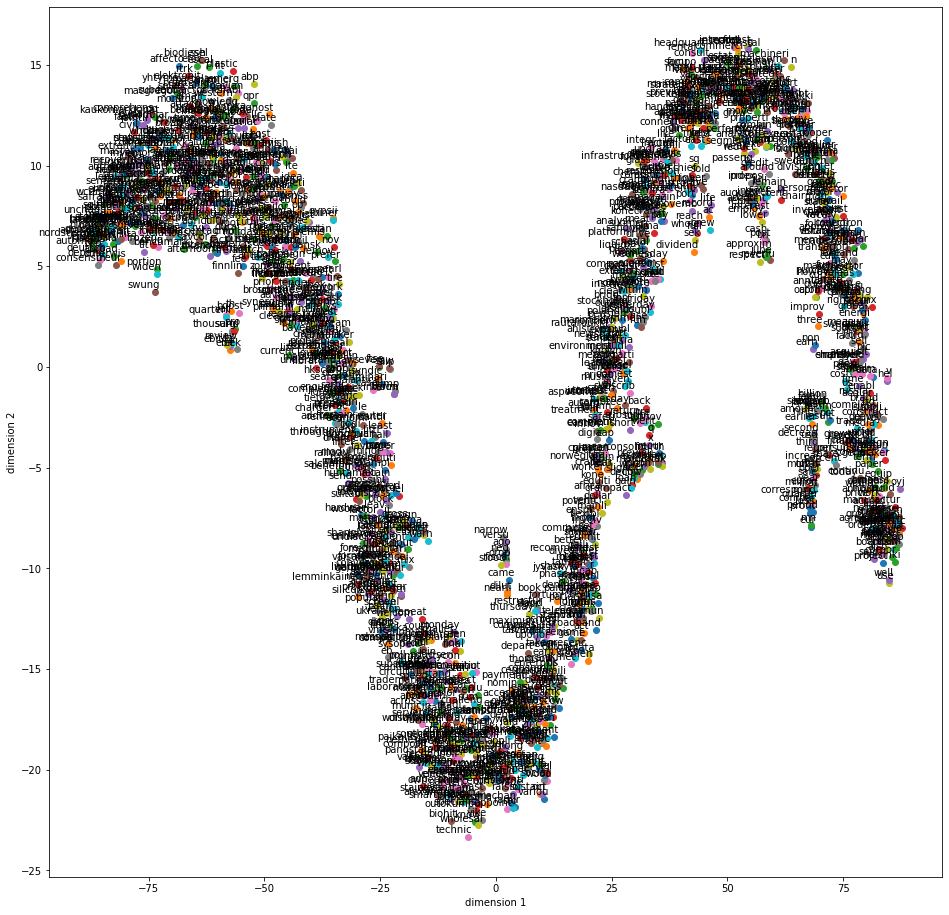

In [32]:
#model = word2vec.Word2Vec(all_words, window=20, min_count=20, workers=4)
tsne_plot()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


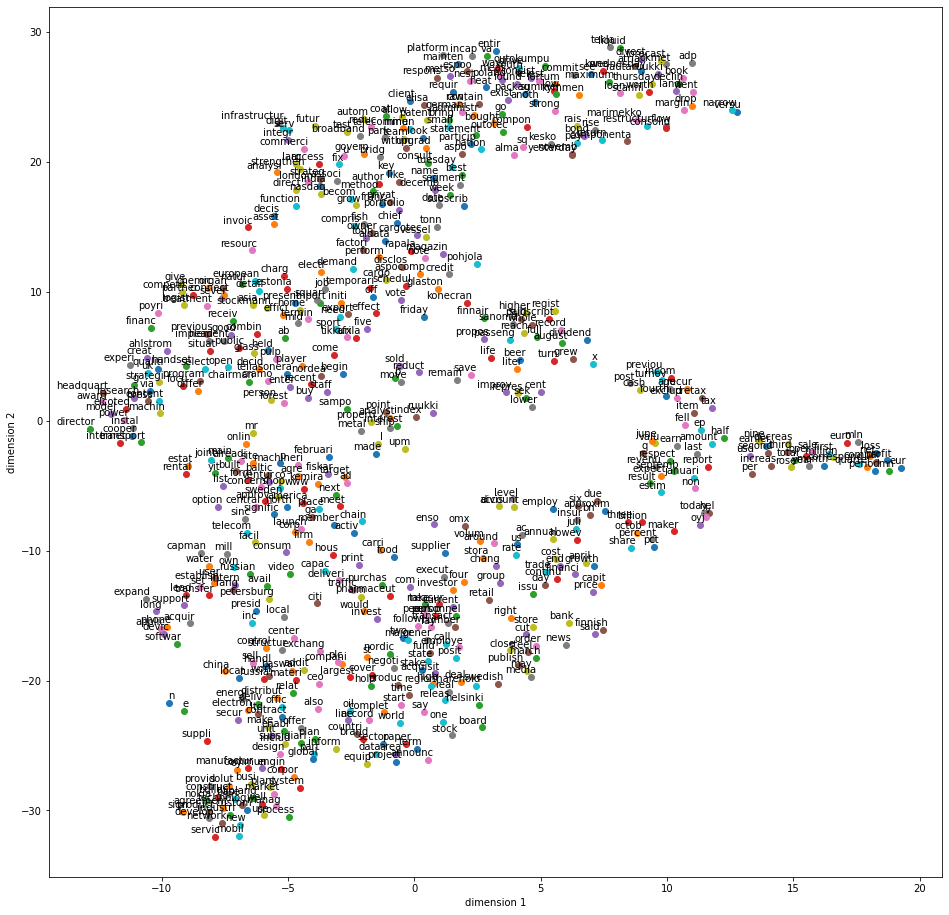

In [33]:
model = gensim.models.Word2Vec(x_tokenized, window=20, min_count=20, workers=4)
tsne_plot()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


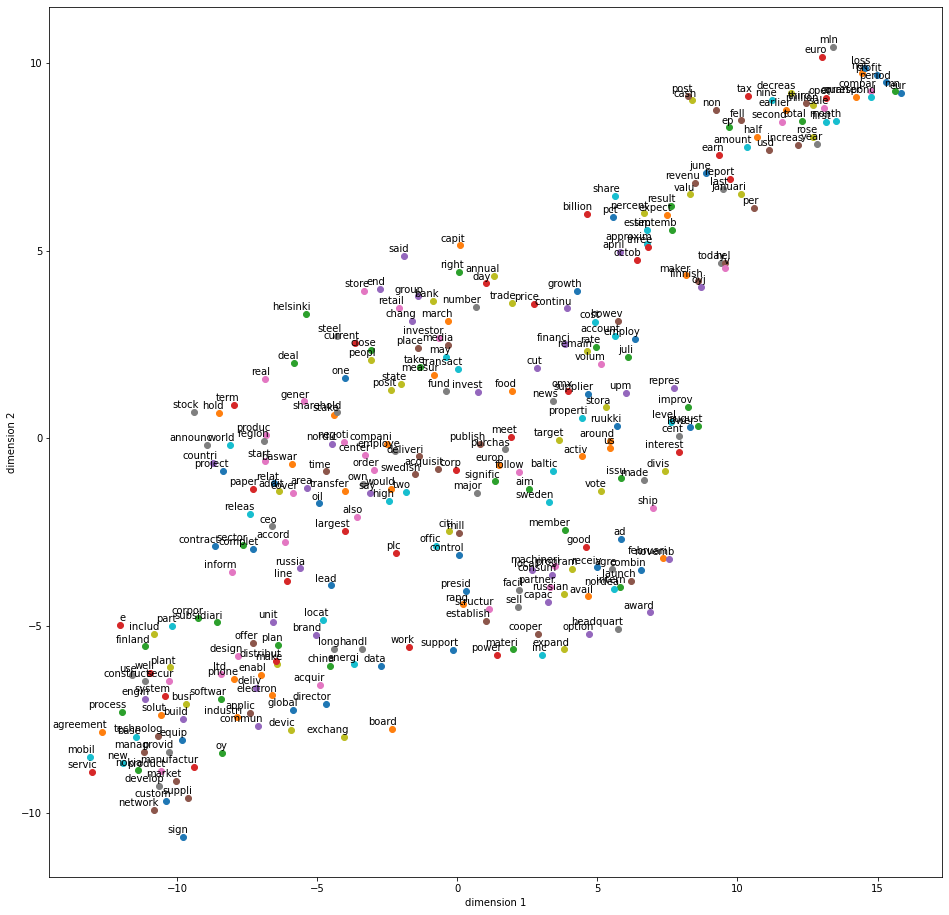

In [34]:
model = gensim.models.Word2Vec(x_tokenized, window=20, min_count=40, workers=4)
tsne_plot()

In [35]:
keys = ['earn', 'profit']

# this array will contain the vectors(dimension 100) and the labels
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [36]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


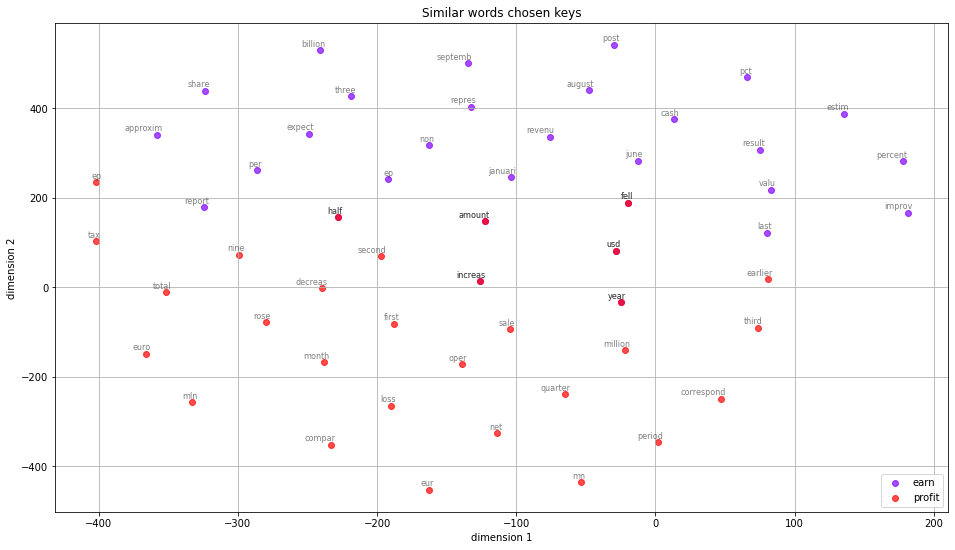

In [37]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words chosen keys', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')